In [1]:
from paths import trefhtmn_members
from paths import trefhtmx_members
from paths import land_mask
import xarray
from matplotlib import rc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas
from cftime import DatetimeNoLeap

In [4]:
# Can do this on just one ensemble member and asssume they'll be comparable, or can do individually on ensemble members and average the result
# Calculate a daily climatology
# Look out for leap years
# Subtract the climatology from each year to calculate the daily anomaly
# Linearly detrend
# Calculate the variance and autocorrelation over time
# Start with the 1980-2010 period
print("init")
def calc_avg_yr_anomalies(xr_ds):
    full_ts = xr_ds.values
    years = np.linspace(1920, 2080, 161)
    average_year = np.zeros((365, 192, 288))
    for year in years:
        average_year += xr_ds.sel(time=slice(DatetimeNoLeap(year, 1, 1), DatetimeNoLeap(year, 12, 31))).values
    average_year = average_year / len(years)

    avg_yr_anomalies = full_ts * 1
    for year_index in range(len(years)):
        avg_yr_anomalies[365*year_index:365*(year_index+1)] -= average_year
    return avg_yr_anomalies

em = xarray.open_dataset(trefhtmn_members()[0][14])["TREFHTMN"]
em.values = calc_avg_yr_anomalies(em)
print("coeff")
em_coeffs = em.stack(paired_points=['lat','lon']).groupby('paired_points').apply(lambda data: data.polyfit("time", 1).polyfit_coefficients).unstack()
em_detrended = em - xarray.polyval(em.time, em_coeffs)

init
coeff


In [14]:
ds = xarray.open_dataset(trefhtmn_members()[0][14])["TREFHTMN"].to_dataframe()

In [35]:
ds = xarray.open_dataset(trefhtmn_members()[0][14])["TREFHTMN"]
ds["time"] = ds.indexes["time"].to_datetimeindex()
ds.mean()

/tmp/ipykernel_118051/3956411592.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds["time"] = ds.indexes["time"].to_datetimeindex()


<xarray.DataArray 'TREFHTMN' ()>
array(275.543, dtype=float32)

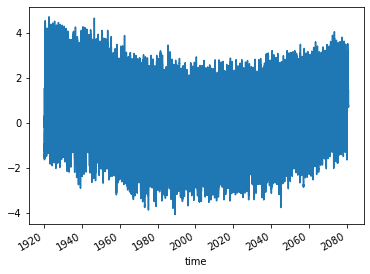

In [68]:
em_detrended.mean(dim="lat").mean(dim="lon").plot()

In [69]:
em.groupby("time.year")

DataArrayGroupBy, grouped over 'year'
161 groups with labels 1920, 1921, 1922, ..., 2079, 2080.

In [11]:
df_h = xarray.open_dataset(trefhtmn_members()[0][14])["TREFHTMN"].to_dataframe().resample("D").mean()  # what we want (quickly), but in Pandas form
vals = [xr.DataArray(data=df_h[c], dims=['time'], coords={'time':df_h.index}, attrs=ds[c].attrs) for c in df_h.columns]
ds_h = xr.Dataset(dict(zip(df_h.columns,vals)), attrs=ds.attrs)

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'MultiIndex'

Text(0.5, 1.0, 'Minimum Daily Temperature')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


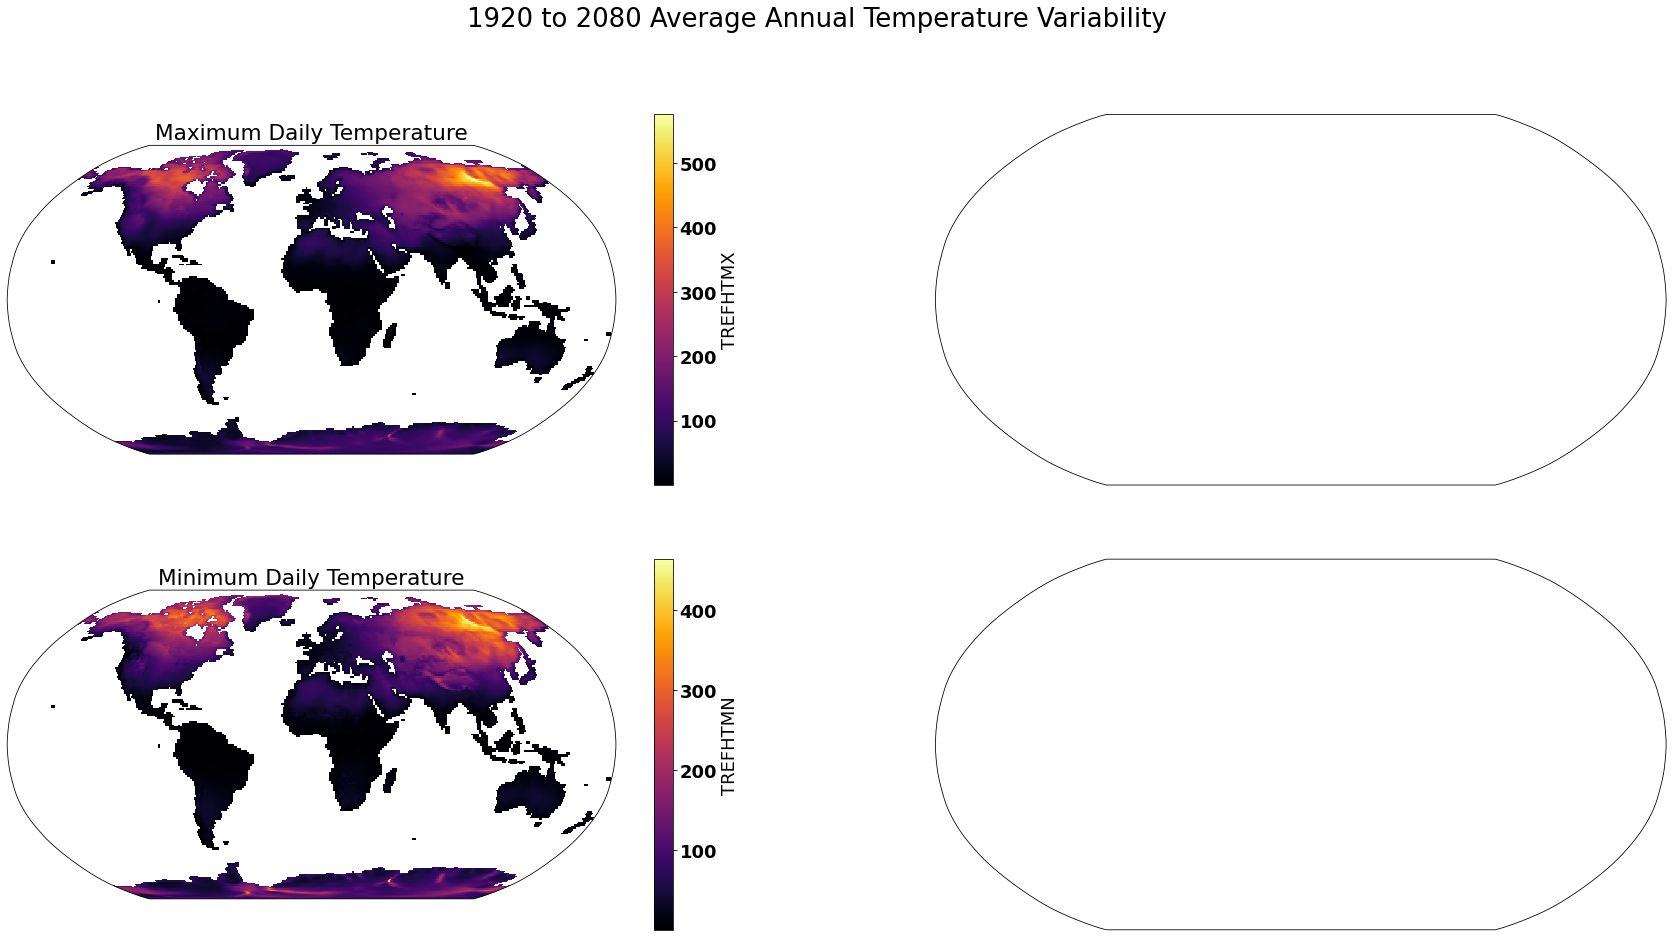

In [31]:
rc('font', **{'weight': 'bold', 'size': 18})
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(30, 15), facecolor='w', subplot_kw={'projection': ccrs.Robinson()})
f.suptitle(f"1920 to 2080 Single Run Average Daily Temperature Variability", fontsize=26)
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'

land_m = xarray.open_dataset(land_mask())["__xarray_dataarray_variable__"]

cmap="inferno"

xarray.open_dataset("tmax_var.nc")["TREFHTMX"].where(land_m>0).plot(ax=ax1, cmap=cmap, transform=ccrs.PlateCarree())
xarray.open_dataset("tmin_var.nc")["TREFHTMN"].where(land_m>0).plot(ax=ax3, cmap=cmap, transform=ccrs.PlateCarree())

ax1.set_title("Maximum Daily Temperature")
ax3.set_title("Minimum Daily Temperature")

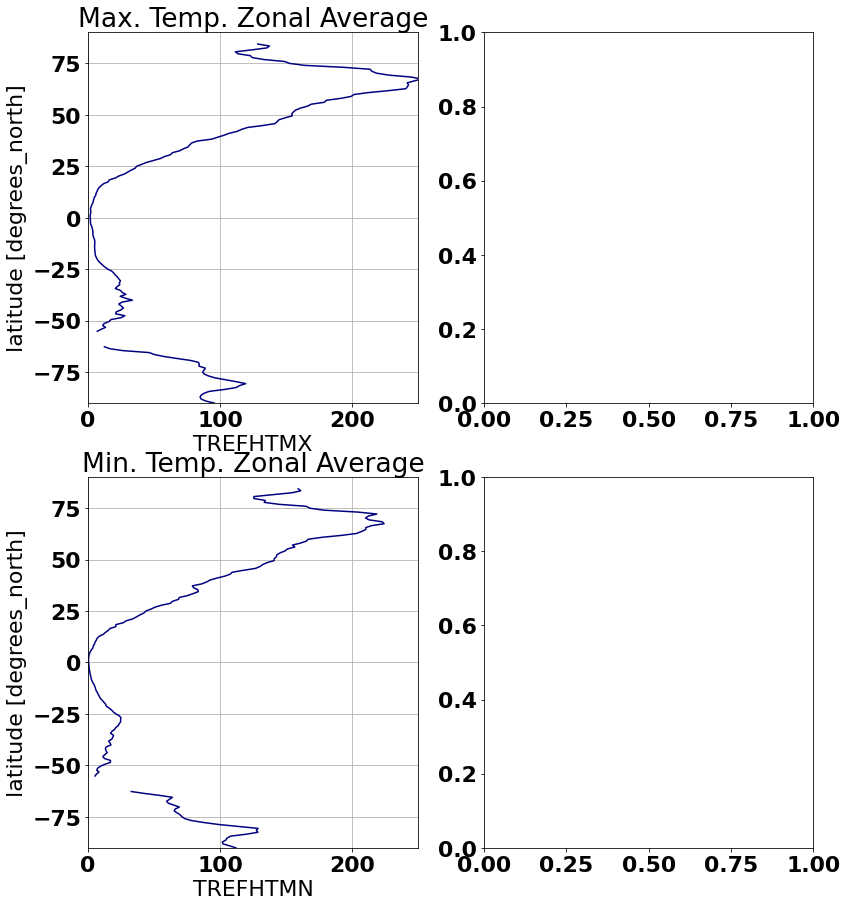

In [27]:
rc('font', **{'family': 'normal', 'weight': 'bold', 'size': 22})
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 15), facecolor='w')
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'

color="navy"

xarray.open_dataset("tmax_var.nc")["TREFHTMX"].where(land_m>0).mean(dim="lon").plot(ax=ax1, y="lat", color=color)
xarray.open_dataset("tmin_var.nc")["TREFHTMN"].where(land_m>0).mean(dim="lon").plot(ax=ax3, y="lat", color=color)

ax1.set_ylim(-90, 90)
ax3.set_ylim(-90, 90)

ax1.set_xlim(0, 250)
ax3.set_xlim(0, 250)

ax1.set_title("Max. Temp. Zonal Average")
ax3.set_title("Min. Temp. Zonal Average")

ax1.grid()
ax3.grid()

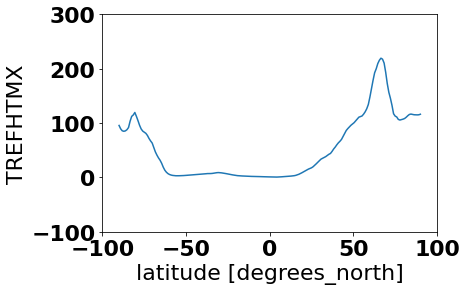

In [30]:
xarray.open_dataset("tmax_var.nc")["TREFHTMX"].mean(dim="lon").plot()